https://neptune.ai/blog/text-classification-tips-and-tricks-kaggle-competitions

In [47]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

import re, string, unicodedata
import random

from io import open

from bs4 import BeautifulSoup
from helper.contractions import CONTRACTION_MAP
from helper.slangs import SLANGS_MAP

import inflect
import unidecode
import emoji

import spacy
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
from spacy.lemmatizer import Lemmatizer

from spellchecker import SpellChecker
from nltk.tokenize import WhitespaceTokenizer

#from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from collections import  Counter


from textblob import TextBlob
#from keras.preprocessing.text import text_to_word_sequence

# global variables
wtk = WhitespaceTokenizer()

In [2]:
# spell checker
spell = SpellChecker()
def correct_spellings(words):
    corrected_text = []
    misspelled_words = spell.unknown(words)
    for word in words:
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
            
    return corrected_text


def spell_correction(text):
    text = TextBlob(text)
    return text.correct()


nlp = spacy.load('en_core_web_md')
def spacy_tokenization_lemma(text):
    text_nlp = nlp(text)
    token_list = []
    for token in text_nlp:
        #token_list.append(token.text)
        if token.lemma_ != '-PRON-':
            token_list.append(token.lemma_)
        
    return token_list

##-- handle punctuations
def _remove_punct(text): 
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*_~'''
    for x in text.lower(): 
        if x in string.punctuation: 
            text = text.replace(x, "")
  
    return text


def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_words.append(_remove_punct(word))
        
    return new_words


# convert emojis
def convert_emoji(text):
    text = emoji.demojize(text)
    return text


# remove html tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text


# remove URL from text
def remove_url(words):
    """Remove URLs from a sample string"""
    # url_rule = r'(?P<url>https?://[^\s]+)'
    word_clean = []
    for word in words:
        text = re.sub(r"http\S+", "", word)
        if text:
            word_clean.append(text)
    return word_clean


### --- handle slangs
def unslang(text):
    """Convert slangs to corresponding english words"""
    wtk = WhitespaceTokenizer()
    words = wtk.tokenize(text)
    slangs = []
    for word in words:
        if word.upper() in SLANGS_MAP.keys():
            slangs.append(SLANGS_MAP[word.upper()])
        else:
            slangs.append(word)
            
    text_slangs = ' '.join(slangs)
    return text_slangs


def expand_contractions(text):
    wtk = WhitespaceTokenizer()
    words = wtk.tokenize(text)
    words_expand = []
    for word in words:
        if word in CONTRACTION_MAP.keys():
            words_expand.append(CONTRACTION_MAP[word])
        else:
            words_expand.append(word)
            
    text_expand = ' '.join(words_expand)
    return text_expand


##--- remove special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


# remove remianing non ascii characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words


### --- lemmatization
#lemmatizer = Lemmatizer(lookups)
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer(word)
        lemmas.append(lemma)
    return lemmas


###---- Remove stop words
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in spacy_stopwords:
            new_words.append(word)
    return new_words


def replace_compound_words(text):
    """Break compound words"""
    text = re.sub('/', ' / ', text)
    text = re.sub('-', ' - ', text)
    text = re.sub('_', ' _ ', text)
    
    return text


# L33T vocabulary (SLOW)
# https://simple.wikipedia.org/wiki/Leet
# Local (only unknown words)
def convert_leet(word):
    # basic conversion 
    word = re.sub('0', 'o', word)
    word = re.sub('1', 'i', word)
    word = re.sub('3', 'e', word)
    word = re.sub('\$', 's', word)
    word = re.sub('\@', 'a', word)
    return word




def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    return text



def normalization(text):
    text = text.lower()
    text = replace_compound_words(text)
    text = spell_correction(text)
    text = convert_emoji(text)
    text = strip_html_tags(text)
    text = expand_contractions(text)
    text = unslang(text)
        
    # Tokenize
    words = spacy_tokenization_lemma(text)
    words = correct_spellings(words)
    words = remove_stopwords(words)
    words = remove_url(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    
    words = ' '.join(words)
    words = words.strip().lower()
    
    return words


In [3]:
train = pd.read_csv("data/train.csv", encoding='utf-8')
test = pd.read_csv("data/test.csv")
submission = pd.read_csv('data/SampleSubmission.csv')

In [4]:
train.dropna(axis=0, subset=('text', 'label'), inplace=True)
test.dropna(axis=0, subset=('text', ), inplace=True)

## EXPLORATORY DATA

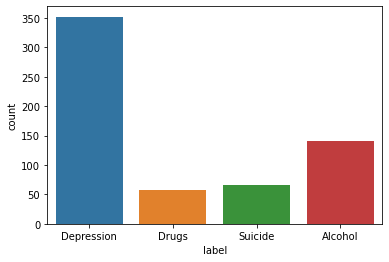

In [5]:
ax = sns.countplot(x='label', data=train)

In [6]:
%%time
train['text_norm'] = train['text'].apply(lambda x: normalization(x))

Wall time: 1min 16s


In [7]:
print(train.shape)
train.head()

(616, 4)


,ID,text,label,text_norm
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,feel dream happy
1,9JDAGUV3,Why do I get hallucinations?,Drugs,hallucination
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,stressed lack financial support school
3,6UY7DX6Q,Why is life important?,Suicide,life important
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,help depression


In [8]:
#%%time
#test['text_norm'] = test['text'].apply(lambda x: normalization(x))

Wall time: 30.7 s


In [9]:
print(test.shape)
test.head()

(309, 3)


,ID,text,text_norm
0,02V56KMO,How to overcome bad feelings and emotions,overcome bad feeling emotion
1,03BMGTOK,I feel like giving up in life,feel like life
2,03LZVFM6,I was so depressed feel like got no strength t...,depressed feel like strength continue
3,0EPULUM5,I feel so low especially since I had no one to...,feel low especially talk
4,0GM4C5GD,can i be successful when I am a drug addict?,successful drug addict


Let's take a look at the number of characters present in each sentence. This can give us a rough idea about the news headline length.  
The average word length ranges between 3 to 9 with 6 being the most common length. this does not necesserily mean people use only short words. this distribution is skewed towards short words due to the number of stop words.


Text(0.5, 1.0, 'Average text length')

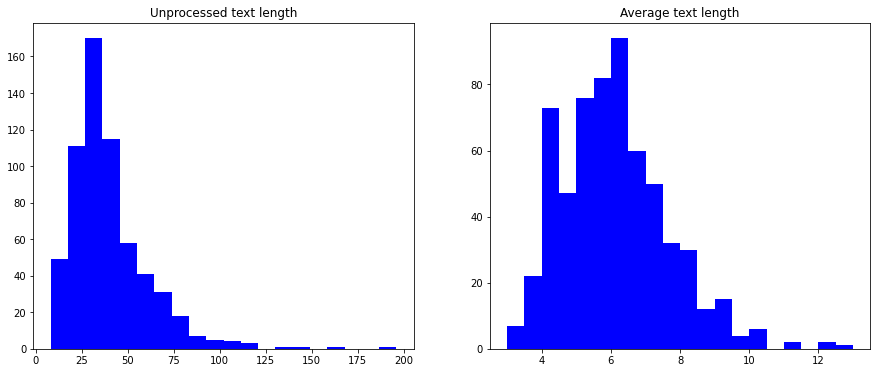

In [28]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
text_len = train['text'].str.len()
ax1.hist(text_len,color='blue', bins=20)
ax1.set_title('Unprocessed text length')

mean_len = train['text_norm'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
ax2.hist(mean_len,color='blue', bins=20)
ax2.set_title('Average text length')

### Analyzing stopwords.  
Analyzing the amount and the types of stopwords can give us some good insights into the data.  

In [52]:
import nltk
#nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')


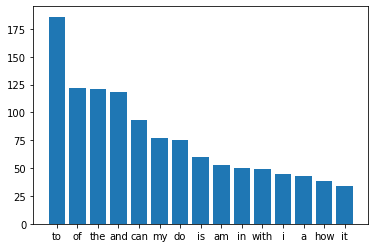

In [53]:
# plot top Stopwords 

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def most_frequent_stopwords(df, text):
        
    all_text = df[text].str.split()
    all_text = all_text.values.tolist()
    corpus=[word for i in all_text for word in i]

    
    dic=defaultdict(int)
    for word in corpus:
        if word in stopwords:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 
    x,y=zip(*top)
    plt.bar(x,y)
    

most_frequent_stopwords(train, 'text')

So now we know which stopwords occur frequently in our text, let’s inspect which words other than these stopwords occur frequently.

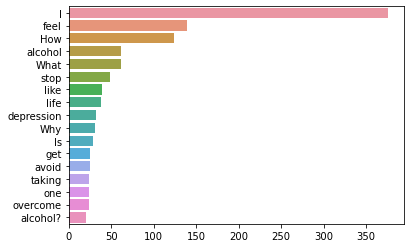

In [54]:

def frequent_non_stopwords(text):
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stopwords):
            x.append(word)
            y.append(count)
    # sns.barplot(x='group', y='Values', data=df, estimator=lambda x: sum(x==0)*100.0/len(x))
    sns.barplot(x=y,y=x)
    
frequent_non_stopwords(train['text'])   

### Ngram exploration.  
Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.  
We can observe that the bigrams such as ‘how can’, ’feel like’ that are related to war dominate the news headlines.

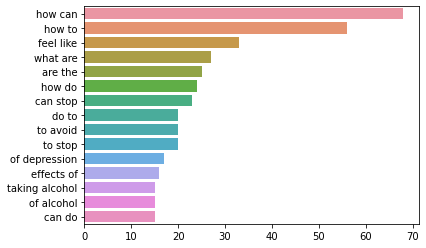

In [58]:
# Code Snippet for Top N-grams Barchart
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n_gram=2, top_n=10):

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:top_n]

    
    top_n_bigrams=_get_top_ngram(text,n_gram)[:top_n]
    x,y=map(list,zip(*top_n_bigrams))
    # sns.barplot(x='group', y='Values', data=df, estimator=lambda x: sum(x==0)*100.0/len(x))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(train['text'], 2, 15)

### word cloud

In [72]:
# Code Snippet for Wordcloud
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer,PorterStemmer

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
nlp = spacy.load('en_core_web_md')
def spacy_lemmatizer(text):
    text_nlp = nlp(text)
    token_list = []
    for token in text_nlp:
        #token.text = token.text.strip("'") # strip 
        if token not in spacy_stopwords and token.lemma_ != '-PRON-':
            token_list.append(token.lemma_)
        
    return token_list

def plot_wordcloud(text):

    def _preprocess_text(texts):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for text in texts:
            tokens = spacy_lemmatizer(text)
            corpus.append(tokens)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

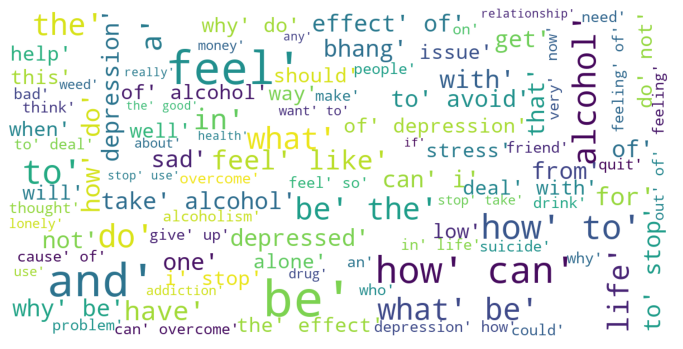

In [73]:
plot_wordcloud(train['text'])

### Textblob to check sentiments.  
We use textblob to evaluate the general sentiment of all the text.  
You can see that the polarity mainly ranges between 0.00 and 0.2. This indicates that the majority of the text are neutral.

In [81]:
#!pip install textblob 
from textblob import TextBlob
    
def plot_polarity_histogram(text):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
        
    polarity_score =text.apply(lambda x : _polarity(x))
    sns.barplot(x='group', y='Values', data=df, estimator=lambda x: sum(x==0)*100.0/len(x))
    
    polarity_score.hist(bins=10)

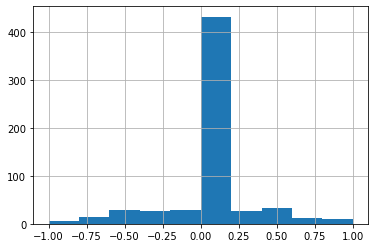

In [82]:
plot_polarity_histogram(train['text'])


lets classify the news as negative, positive and neutral based on the scores

In [88]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

def sentiment_vader(text, sid):
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)

def sentiment_textblob(text):
        x = TextBlob(text).sentiment.polarity
        
        if x<0:
            return 'neg'
        elif x==0:
            return 'neu'
        else:
            return 'pos'

def plot_sentiment_barchart(text, method='TextBlob'):
    if method == 'TextBlob':
        sentiment = text.map(lambda x: sentiment_textblob(x))
    elif method == 'Vader':
        
        sid = SentimentIntensityAnalyzer()
        sentiment = text.map(lambda x: sentiment_vader(x, sid=sid))
    else:
        raise ValueError('Textblob or Vader')
    
    plt.bar(sentiment.value_counts().index,sentiment.value_counts())
    
    return sentiment


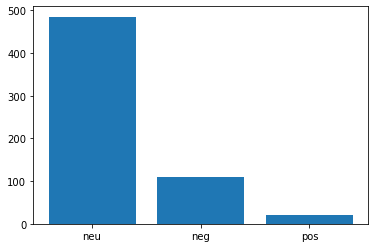

In [90]:
sentiment = plot_sentiment_barchart(train['text'], method='Vader')
train['polarity'] = sentiment

Let’s take a look at some of the positive and negative text

In [93]:
train[train['polarity']=='pos'].head(10)

,ID,text,label,text_norm,polarity
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,feel dream happy,pos
23,P4T442GZ,"Sadness,hatredNow feeling is happiness",Depression,sadness hatrednow feeling happiness,pos
66,HD9XSQZD,Lonely and happiness,Depression,lonely happiness,pos
92,DQYT5T05,Feeling lonelyNow I feel better,Depression,feel lonelynow feel better,pos
112,SD3C3HNH,Challenging,Depression,challenging,pos
114,PBVEUVY5,I can't stop smoking weed because of the good ...,Drugs,stop smoke weed good feeling calmness,pos
150,UVSIAT7E,I feel like giving up everything,Depression,feel like,pos
159,AWQDGRT6,i feel well okay,Depression,feel okay,pos
230,0UNXTGLP,How can i motivate myself when feeling low,Depression,motivate feel low,pos
242,X0YHNC8N,I feel like giving up,Depression,feel like,pos


### Exploration through Parts of Speach Tagging.  
We can clearly see that the noun (NN) dominates in the text followed by prepositions (PRP).

In [98]:
# Code Snippet for Parts of Speach Barchart

from nltk.tokenize import word_tokenize
import seaborn as sns
from collections import Counter

def plot_parts_of_speach_barchart(text, n=10):
    #nltk.download('averaged_perceptron_tagger')

    def _get_pos(text):
        pos=nltk.pos_tag(word_tokenize(text))
        pos=list(map(list,zip(*pos)))[1]
        return pos
    
    tags=text.apply(lambda x : _get_pos(x))
    tags=[x for l in tags for x in l]
    counter=Counter(tags)
    x,y=list(map(list,zip(*counter.most_common(n))))
    
    sns.barplot(x=y,y=x)

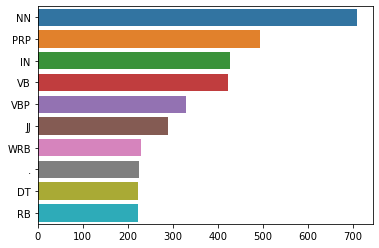

In [99]:
plot_parts_of_speach_barchart(train['text'])

investigate the most frequent noun used in our domain.  
Nouns such as 'alcohol', 'depression' and life dominate the text.

In [102]:
def plot_most_common_part_of_speach(text, part_of_speach='NN', n=10):
    #nltk.download('averaged_perceptron_tagger')
    
    def _filter_pos(text):
        pos_type=[]
        pos=nltk.pos_tag(word_tokenize(text))
        for word,tag in pos:
            if tag==part_of_speach:
                pos_type.append(word)
        return pos_type

    words=text.apply(lambda x : _filter_pos(x))
    words=[x for l in words for x in l]
    counter=Counter(words)
    x,y=list(map(list,zip(*counter.most_common(n))))
    sns.barplot(x=y,y=x).set_title(part_of_speach)
    

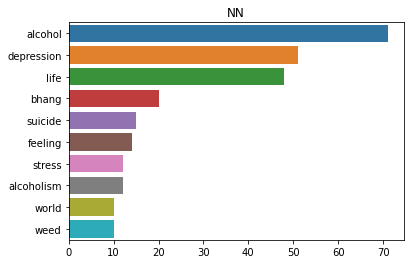

In [103]:
plot_most_common_part_of_speach(train['text'], n=10)

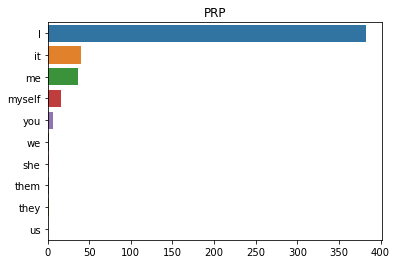

In [105]:
plot_most_common_part_of_speach(train['text'], 'PRP', 10)

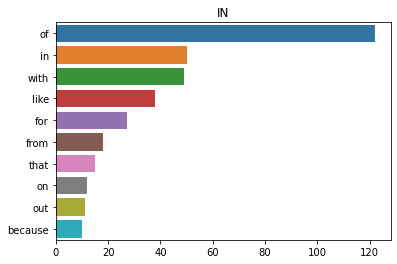

In [113]:
plot_most_common_part_of_speach(train['text'], 'IN', 10)

### Explore text complexity.  
It can be very informative to know how readable (difficult to read) the text is and what type of reader can fully understand it. Do we need a college degree to understand the message or a first-grader can clearly see what the point is?

You can actually put a number called readability index on a document or text. Readability index is a numeric value that indicates how difficult (or easy) it is to read and understand a text.

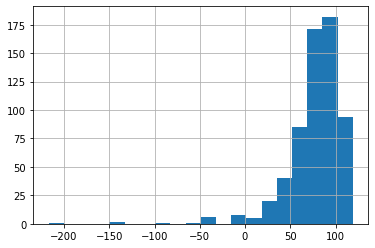

In [111]:
from textstat import flesch_reading_ease
#!pip install textstat

def text_complexity(text):
    reading = text.apply(lambda x : flesch_reading_ease(x))
    reading.hist(bins=20)
    
    return reading

reading = text_complexity(train['text'])

Almost all of the readability scores fall above 50. This means that an average 11-year-old student can read and understand the text. Let’s check all news headlines that have a readability score below 5

In [112]:
x=[i for i in range(len(reading)) if reading[i]<5]
train.iloc[x]['text'].head()

7                     I feel emotionally overwhelmed 
23             Sadness,hatredNow feeling is happiness
26                 Deteriorating academic performance
95    My feelings were chaotic,sad,isolatedNow better
97       Was sad,lonely,confusedNow happy and content
Name: text, dtype: object

### Topic modelling

### Explore label distribution

In [10]:
train['label'].unique()

array(['Depression', 'Drugs', 'Suicide', 'Alcohol'], dtype=object)

It is clear that the number of words in text ranges from 1 to 15 and mostly falls between 2 to 5 words.

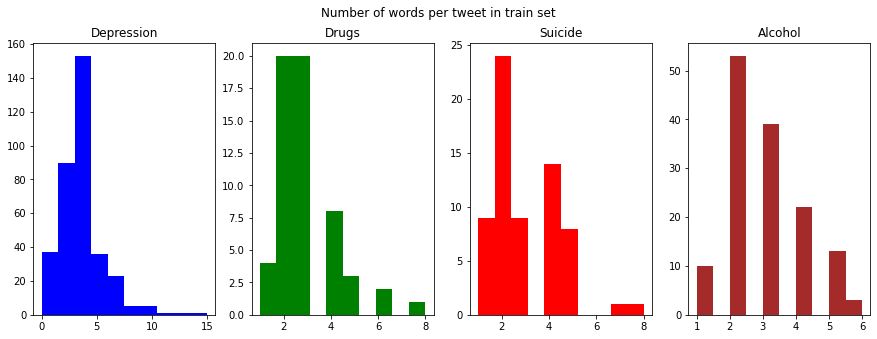

In [11]:
fig,(ax1,ax2, ax3, ax4) = plt.subplots(1,4,figsize=(15,5))

train_len = train[train['label'] == 'Depression']['text_norm'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color='blue')
ax1.set_title('Depression')

train_len = train[train['label'] == 'Drugs']['text_norm'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color='green')
ax2.set_title('Drugs')

train_len = train[train['label'] == 'Suicide']['text_norm'].str.split().map(lambda x: len(x))
ax3.hist(train_len,color='red')
ax3.set_title('Suicide')

train_len = train[train['label'] == 'Alcohol']['text_norm'].str.split().map(lambda x: len(x))
ax4.hist(train_len,color='brown')
ax4.set_title('Alcohol')

fig.suptitle('Number of words per tweet in train set')
plt.show()

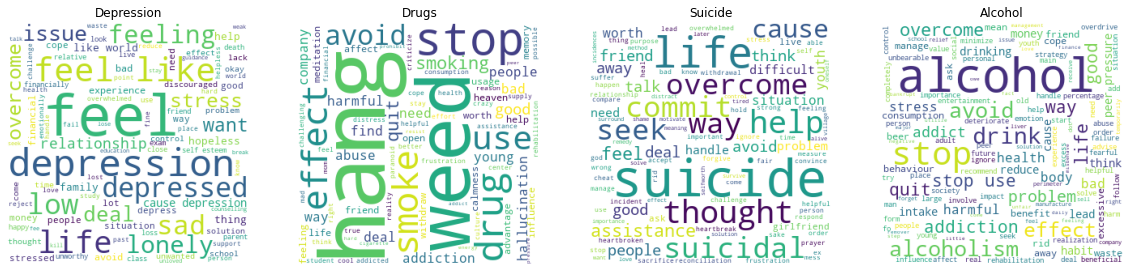

In [13]:
stopwords = set(STOPWORDS)

labels=['Depression', 'Drugs', 'Suicide', 'Alcohol']
fig, ax = plt.subplots(1,4, figsize=(20,11))
for i,s in enumerate(labels):
    
    tot_token = ''
    tot_token +=' '.join(train.loc[train['label']==s,'text_norm'])
    wordcloud = WordCloud(width=300, height=300, background_color='white',
                     stopwords = stopwords, min_font_size=6).generate(tot_token)

    ax[i].imshow(wordcloud)  
    ax[i].set_title(s)
    ax[i].axis('off')

D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


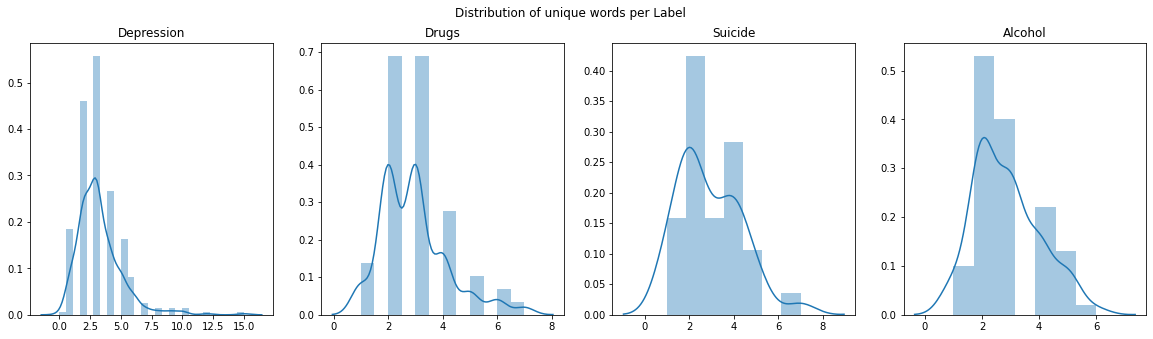

In [14]:
def distribution_unique_word(df):
    fig,ax = plt.subplots(1,4, figsize=(20,5))
    for i,s in enumerate(labels):
        new = train[train['label']==s]['text_norm'].map(lambda x: len(set(x.split())))
        sns.distplot(new.values, ax=ax[i])
        ax[i].set_title(s)
    fig.suptitle('Distribution of unique words per Label')
    fig.show()

distribution_unique_word(train)

## Evaluating vocabulary embeddings

In [ ]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

In [114]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [115]:
vocab = build_vocab(train['text_norm'])

In [116]:
len(vocab)

556

# BERT Implementation

In [129]:
# !pip install bert-for-tf2
# https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [133]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')


SystemError: GPU device not found

In [134]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


No GPU available, using the CPU instead.


In [130]:
# Load the BERT tokenizer.

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

When we actually convert all of our sentences, we’ll use the tokenize.encode function to handle both steps, rather than calling tokenize and convert_tokens_to_ids separately.

In [131]:
#sentences = train['text_norm'].to_list()
sentences = train['text_norm'].values
labels = df.label.values

# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))


 Original:  feel dream happy
Tokenized:  ['feel', 'dream', 'happy']
Token IDs:  [2514, 3959, 3407]


In [132]:
# get max sequence length
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Max sentence length:  19


### Tokenize Dataset

In [147]:
from sklearn.preprocessing import LabelEncoder

# encode class values as integers
Y = train['label'].values
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

# convert integers to dummy variables (i.e. one hot encoded)
labels = np_utils.to_categorical(encoded_Y)

sentences = train['text_norm'].values

In [146]:
#encoder.classes_
#encoder.inverse_transform([1])

array(['Depression'], dtype=object)

In [148]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,      # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

    
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


Original:  feel dream happy
Token IDs: tensor([ 101, 2514, 3959, 3407,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0])


### Training & Validation Split

In [152]:
from torch.utils.data import TensorDataset, random_split
from sklearn.model_selection import train_test_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


  523 training samples
   93 validation samples


We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [153]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [167]:
type(train_dataset)

torch.utils.data.dataset.Subset

## Train Our Classification Model

### BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

Here is the current list of classes provided for fine-tuning:

In [155]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
#model.cuda()


In [157]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

##  Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

        Batch size: 16, 32
        Learning rate (Adam): 5e-5, 3e-5, 2e-5
        Number of epochs: 2, 3, 4



In [158]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 )


In [159]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


### 4.3. Training Loop

Below is our training loop. There’s a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase.

    Thank you to Stas Bekman for contributing the insights and code for using validation loss to detect over-fitting!

Training:

    Unpack our data inputs and labels
    Load data onto the GPU for acceleration
    Clear out the gradients calculated in the previous pass.
        In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
    Forward pass (feed input data through the network)
    Backward pass (backpropagation)
    Tell the network to update parameters with optimizer.step()
    Track variables for monitoring progress

Evalution:

    Unpack our data inputs and labels
    Load data onto the GPU for acceleration
    Forward pass (feed input data through the network)
    Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we’ve commented the code to point out which of the above steps are happening on each line.

    PyTorch also has some beginner tutorials which you may also find helpful.

Define a helper function for calculating accuracy.

In [160]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [161]:
# Helper function for formatting elapsed times as hh:mm:ss
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [162]:
## Training

In [163]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...


ValueError: Expected input batch_size (32) to match target batch_size (128).

In [ ]:
#Let’s view the summary of the training process.

import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()


## 5. Performance On Test Set

### Data Preparation
We’ll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [ ]:

import pandas as pd

# Load the dataset into a pandas dataframe.
#df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


## Evaluate on Test Set
With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,attention_mask=b_input_mask)

    logits = outputs[0]

  # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')


Accuracy on the CoLA benchmark is measured using the “Matthews correlation coefficient” (MCC).

We use MCC here because the classes are imbalanced:

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)


The final score will be based on the entire test set, but let’s take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.

Each batch has 32 sentences in it, except the last batch which has only (516 % 32) = 4 test sentences in it.


In [ ]:

# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()


In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)
